# Program for batch normalization and advance congifuration fitting of XANES spectra

# Input data for this code

In [2]:
mainh5path   = "DurangoStd1/es942_DurangoStd1.h5"
cfgfilepath  = "config_example.cfg"
outpath      = "out/"
elemdet      = "fx2_det0_SKa"  #  Select the element and detectors with data
elemdetnorm  = "SKa_corr_norm0" #  Select the element and counter with normalization correction
energycntr   = "enegoat"       # Select energy counter
matchers     = ["DurangoStd1_poi1361_1201"]  #  Filter to fit all the the files from the same sample with that name
trhnpoi      = 251   #  Treshold to filter the data with less number of points in the spectrum than trhdnpoi
wlbkgratio   = 2.0   #  Ratio for the filter between the max of the white line and the mean of the pre edge background
nopoibckg    = 15    #  Number of points to take the mean of the background level

# Normalization values
edge = 2.48
pre  = "Constant", -0.01117, -0.008483
post = "Constant", 0.028208, 0.036334

# Choosing with a "yes" or "no"
savespectresults  = "yes"  #  Save the components and the norm spectrum as xy in a single .csv file for each scan
savefittedresults = "yes"  #  Save the Fitted and sigma values for each component of gaussians areas for ALL the scans, in a single .csv file
showeachplot      = "yes"  #  Show each plot (normalization and fitting) must close each to see next one

saveaverage       = "yes"  #  Write "yes" to create files with the average of poi with several scans

# Imports needed for the program

In [3]:
import os
import re
import h5py
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from contextlib import contextmanager
from PyMca5.PyMcaIO import ConfigDict
from PyMca5.PyMcaMath.fitting import SimpleFitModule
from PyMca5.PyMcaMath.fitting import SimpleFitUserEstimatedFunctions
from PyMca5.PyMcaPhysics.xas.XASNormalization import XASNormalization

# All the functions for the program

In [4]:
@contextmanager
def openh5(filename):
    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    with h5py.File(filename, mode="r") as f:
        yield f


def fileselection():
    with openh5(mainh5path) as f:
        first_keys = list(f.keys())
        #print("file name = ", first_keys)
        for i in range(len(first_keys)):
            file_name = str(first_keys[i])
            #print("file name as list = ", file_name)
            try:
                all_data_files = f[file_name + "/measurement"]
            except Exception as ex:
                print("The error exception in fileselection() is = ", ex)
                badfiles.append(file_name)
                continue

            #print("file name = ", all_data_files)
            if ((elemdet in all_data_files) and (energycntr in all_data_files)):
                goodfiles.append(file_name)
            else:    
                badfiles.append(file_name)
            

def fileselectiontags():
    with openh5(mainh5path) as f:
        first_keys = list(f.keys())
        counter = 0
        xanesinseq = []
        counterseq= 0 
        
        for i in range(len(first_keys)):
            file_name = str(first_keys[i])
            try:
                datacheck = f[file_name]
                datacheck = datacheck["title"][()]
                datacheck = str(datacheck)
                #print("XANES or sequence of scans check = ", datacheck)
            except Exception as ex:
                print("The error exception in fileselectiontags() is = ", ex)
                badfiles.append(file_name)
                continue
            
            if ("sequence_of_scans" in datacheck):
                counterseq += 1 
                xanesinseq.append(counter)
                counter = 0
                #print("SEQUENCEEEEEEEEEEEEEEEEEEEEEEEEEEEEE = ", datacheck)
            elif (("zaptraj enetraj" in datacheck) or ("zaptrajund enetraj" in datacheck) or ("ascan enmonound" in datacheck)):
                counter += 1
                #print("XANESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS = ", datacheck)
                goodfiles.append(file_name)
        xanesinseq.append(counter)
        xanesinseq = xanesinseq[1:]
        #print("List with number of XANES from each sequence scan = ", xanesinseq)
        return xanesinseq


def readspectrum(eachfile):
    with openh5(mainh5path) as f:
        data = f[eachfile + "/measurement"]
        if elemdetnorm in data:
            names = [energycntr, elemdetnorm]
        elif energycntr and elemdet and "iodet" and "fx2_det0_fractional_dead_time" in data:
            print("Elemdetnorm not found, corr_norm done in this code = ", eachfile)
            names = [energycntr, elemdet, "iodet", "fx2_det0_fractional_dead_time"]
        else:
            print("Element det_norm not found and not normalized = ", eachfile)
            names = [energycntr, elemdet]
            
        npoints = min(data[name].shape[0] for name in names)
        energy  = data[energycntr][:npoints]

        # Checking for element correction normalization
        if elemdetnorm in data:
            spectrum = data[elemdetnorm][:npoints]
            #print("element Ka norm present")
        elif energycntr and elemdet and "iodet" and "fx2_det0_fractional_dead_time" in data:   
            iodet = data["iodet"][:npoints]
            #print('iodet = ', iodet)
            det0 = data[elemdet][:npoints]
            #print('det0 = ', det0)
            det0_dead_time = data["fx2_det0_fractional_dead_time"][:npoints]
            #print('det0_dead_time = ', det0_dead_time )
            absorb_norm0 = (det0 / (iodet * (1 - det0_dead_time)))
            #print('absorb_norm0 = ', absorb_norm0)
            spectrum = absorb_norm0
            #print('spectrum = ', spectrum)
        else:
            spectrum = data[elemdet][:npoints]
    return energy, spectrum


def averaging():
    n=-1
    avgenergylist = []
    avgspectrumlist = []
    avgfilenamelist = []
    print("")
    #print("All scans names in h5 = ", len(xanesinseq))
    #print("Number of repeats on each scan = ", xanesinseq)
        
    for i in range(len(xanesinseq)):
        #print("i = ", i)
        avgspectrum = []
        avgspectrum = [0]
        for j in range(xanesinseq[i]):
            try:
                #print("j = ", j)
                n +=1
                #print("Next file is = ", filesforavg[n])
                energy, spectrum = readspectrum(filesforavg[n])
                if len(avgspectrum) > 1:
                    minno = min(len(avgspectrum), len(spectrum), len(energy))
                    avgspectrum = avgspectrum[:minno]
                    spectrum = spectrum[:minno]
                    energy = energy[:minno]
                avgspectrum = np.add(avgspectrum, spectrum)
            except Exception as ex:
                print("The error exception in averaging() is = ", ex)
                continue
    
        if not int(xanesinseq[i]) <= 1:
           avgspectrum = avgspectrum/(int(xanesinseq[i]))
           avgfilename = "AVG_" + filesforavg[n]
           avgenergylist.append(energy)
           avgspectrumlist.append(avgspectrum)
           avgfilenamelist.append(avgfilename)
           # plot(energy, avgspectrum, avgfilename) # Plotting each XANES averaged spectra
    return avgenergylist, avgspectrumlist, avgfilenamelist


def validatespectrum():
    if ((len(energy) < trhnpoi) or (len(spectrum) < trhnpoi) or (all(elem == spectrum[5] for elem in spectrum))):
        print("(Energy or spectrum) < trhdnpoi or all elements are the same" )
        return False
    choosing = max(spectrum) / np.mean(spectrum[2:nopoibckg])
    print("Edge/bckg ratio = ", choosing)
    #print("sigma", (spectrum[:nopoibckg]).std())
    if choosing >= wlbkgratio:
        print("File Validated")
        return True


def normalization(energy, spectrum, edge, pre, post):
    polynomial_map = {
        "Modif. Victoreen": -2,
        "Victoreen": -1,
        "Constant": 0,
        "Linear": 1,
        "Parabolic": 2,
        "Cubic": 3,
    }
    prename, premin, premax    = pre
    postname, postmin, postmax = post

    pre_edge_regions  = [[premin, premax]]
    post_edge_regions = [[postmin, postmax]]
    algorithm = "polynomial"
    algorithm_parameters = {
        "pre_edge_order": polynomial_map[prename],
        "post_edge_order": polynomial_map[postname],
    }

    result = XASNormalization(
        spectrum=spectrum,
        energy=energy,
        edge=edge,
        pre_edge_regions=pre_edge_regions,
        post_edge_regions=post_edge_regions,
        algorithm=algorithm,
        algorithm_parameters=algorithm_parameters,
    )
    (
        energy,
        normalizedSpectrum,
        edge,
        jump,
        pre_edge_function,
        prePol,
        post_edge_function,
        postPol,
    ) = result
    preLine  = pre_edge_function(prePol, energy)
    postLine = post_edge_function(postPol, energy)
    return normalizedSpectrum, jump, preLine, postLine


def fit(energy, normspectrum, cfgname):
    fitcfg = ConfigDict.ConfigDict()
    fitcfg.read(cfgname)
    fitmodel = SimpleFitModule.SimpleFit()
    fitmodel.importFunctions(SimpleFitUserEstimatedFunctions)
    fitmodel.loadUserFunctions()
    fitmodel.configure(fitcfg)
    fitmodel.setData(energy, normspectrum)
    fitmodel.estimate()
    fitresult = fitmodel.fit()
    return fitmodel.evaluateContributions(energy), fitresult

    
def savesingles(energy, normspectrum, file_name):
    combined  = np.vstack((energy, normspectrum)).T
    np.savetxt(outpath + file_name + "_norm" + ".dat", combined, fmt='%10.6f')
    combined2  = np.vstack((energy, fitcomponents["yfit"])).T
    np.savetxt(outpath + file_name + "_normfit" + ".dat", combined2, fmt='%10.6f')
    combined3  = np.vstack((energy, fitcomponents["background"])).T
    np.savetxt(outpath + file_name + "_bckg" + ".dat", combined3, fmt='%10.6f')
    for j, component in enumerate(fitcomponents["contributions"]):
        combined4  = np.vstack((energy, fitcomponents["background"] + fitcomponents["contributions"][j])).T
        np.savetxt(outpath + file_name + "_component" + str(j + 1) + ".dat", combined4, fmt='%10.6f')


def savedatanp(energy, normspectrum, file_name):
    orange_file = []
    first_csv_column = ['Energy(keV)']
    orange_file.append(normspectrum)
    first_csv_column.append(file_name + "_Norm")
    orange_file.append(fitcomponents["yfit"])
    first_csv_column.append(file_name + "_Norm+fit")
    orange_file.append(fitcomponents["background"])
    first_csv_column.append(file_name + "_Background")
    for j, component in enumerate(fitcomponents["contributions"]):
        orange_file.append(fitcomponents["background"] + fitcomponents["contributions"][j])
        first_csv_column.append(file_name + "_Component" + str(j + 1))

    orange_file.insert(0, energy)
    np.savetxt(outpath + file_name + "_Components.csv", orange_file, fmt='%10.6f', delimiter=',')
    return first_csv_column


def savedatapn(energy, normspectrum, file_name):
    orange_file = []
    first_csv_column = ['Energy(keV)']
    orange_file.append(normspectrum)
    first_csv_column.append(file_name + "_Norm")
    orange_file.append(fitcomponents["yfit"])
    first_csv_column.append(file_name + "_Norm+fit")
    orange_file.append(fitcomponents["background"])
    first_csv_column.append(file_name + "_Background")
    for j, component in enumerate(fitcomponents["contributions"]):
        orange_file.append(fitcomponents["background"] + fitcomponents["contributions"][j])
        first_csv_column.append(file_name + "_Component" + str(j + 1))

    orange_file.insert(0, energy)
    df = pd.DataFrame(orange_file)
    df.insert(0, "Energy values", first_csv_column)
    df.to_csv(outpath +  file_name + "_Components.csv", index=False, header=False, float_format='%10.6f')


def add_col(path_in, lst_col, path_out):
    file_in = open(path_in, "r")
    in_line_lst = file_in.readlines()
    file_in.close()
    file_out = open(path_out, "w")
    for position, str_line in enumerate(in_line_lst):
        wrstring = str(lst_col[position] + ',') + str_line
        file_out.write(wrstring)
    file_out.close()


def fitresults():
    parameters = fitresult['result']['parameters']
    fitvalue   = fitresult['result']['fittedvalues']
    sigmavalue = fitresult['result']['sigma_values']
    A1 = fitvalue[6]
    A3 = fitvalue[14]
    A4 = fitvalue[18]
    A6 = fitvalue[26]
    ratiosas = ((A1) / (A1+A3+A4+A6))
    parameters.append("A1/(A1+A3+A4+A6)")
    fitvalue.append(ratiosas)
    return parameters, fitvalue, sigmavalue

    
def plotting(energy, spectrum, normspectrum, file_name):
    plt.figure().suptitle("Norm_" + file_name)
    plt.plot(energy, spectrum)
    plt.vlines([edge], spectrum.min(), spectrum.max(), label="edge", colors=["blue"])
    plt.plot(energy, preline, label="pre")
    plt.vlines(
        edge + np.array(pre[1:]),
        spectrum.min(),
        spectrum.max(),
        label="pre limits",
        colors=["red"],
    )
    plt.plot(energy, preline + postline, label="post")
    plt.vlines(
        edge + np.array(post[1:]),
        spectrum.min(),
        spectrum.max(),
        label="post limits",
        colors=["green"],
    )
    plt.legend(prop={'size': 8})
    plt.title("Pre normalization values")
    plt.xlabel("Energy")
    plt.ylabel("intensity [a.u]")
    plt.figure().suptitle("Fit_" + file_name)
    plt.plot(energy, normspectrum, label="Norm")
    plt.plot(energy, fitcomponents["yfit"], label="Norm+fit")
    plt.plot(energy, fitcomponents["background"], label="Background")
    for i, component in enumerate(fitcomponents["contributions"]):
        plt.plot(
        energy, 
        fitcomponents["background"] + fitcomponents["contributions"][i], 
        label="Component{}".format(i + 1),
        )
    plt.legend(prop={'size': 7})
    plt.title("Advance fitting")
    plt.xlabel("Energy")
    plt.ylabel("intensity [a.u]")
    plt.show()


# Start the loop to run all the functions


File =  DurangoStd1_poi1361_1201: 10.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 10.1
Edge/bckg ratio =  6.145848391480724
File Validated


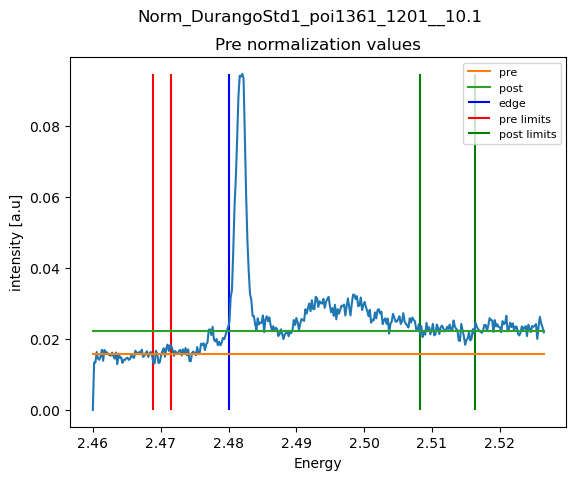

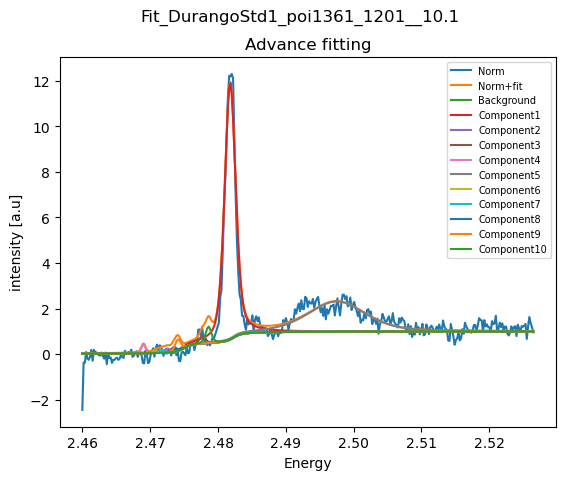


File =  DurangoStd1_poi1361_1201: 11.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 11.1
Edge/bckg ratio =  7.493793600333982
File Validated


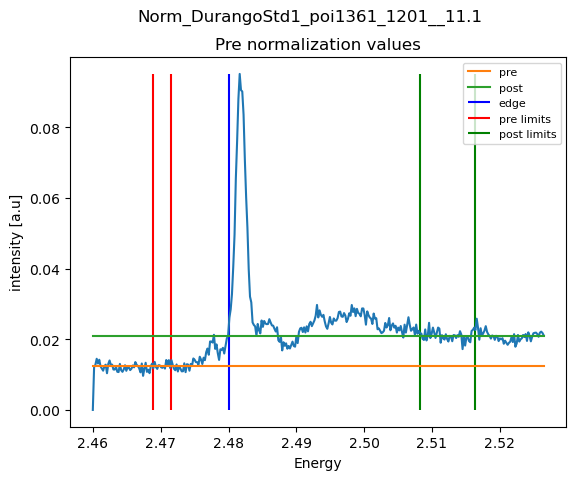

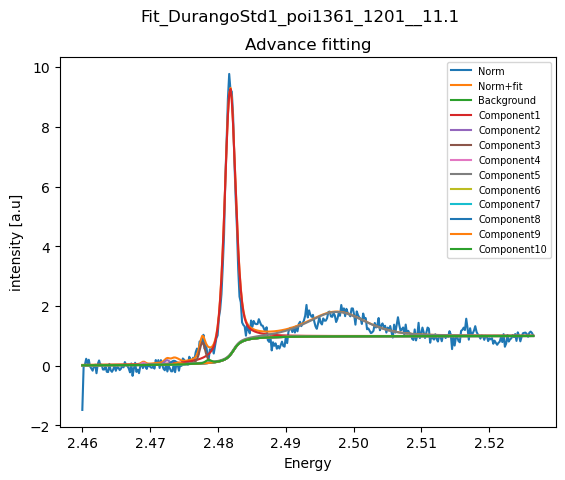


File =  DurangoStd1_poi1361_1201: 2.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 2.1
Edge/bckg ratio =  6.937168731376123
File Validated


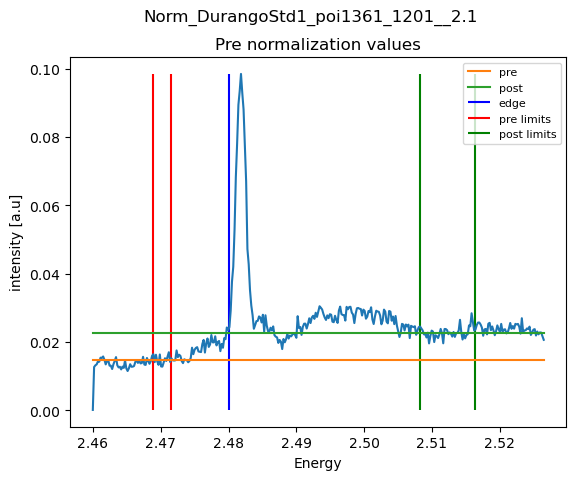

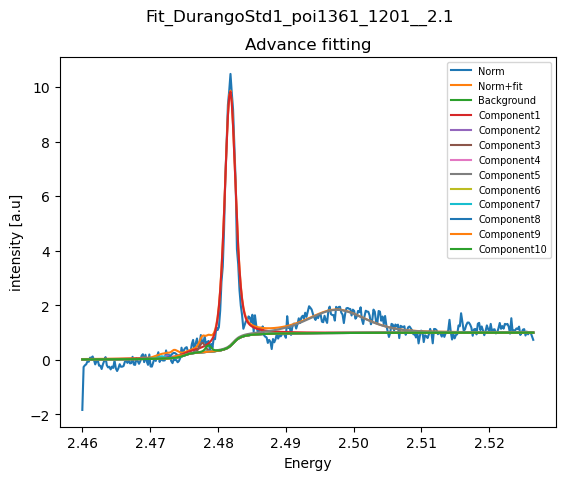


File =  DurangoStd1_poi1361_1201: 3.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 3.1
Edge/bckg ratio =  7.708379151818743
File Validated


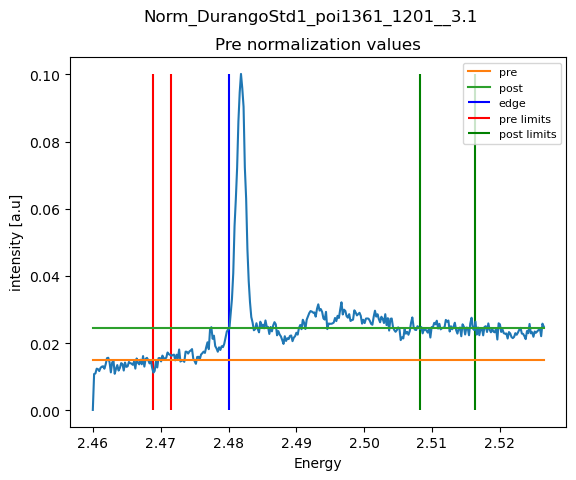

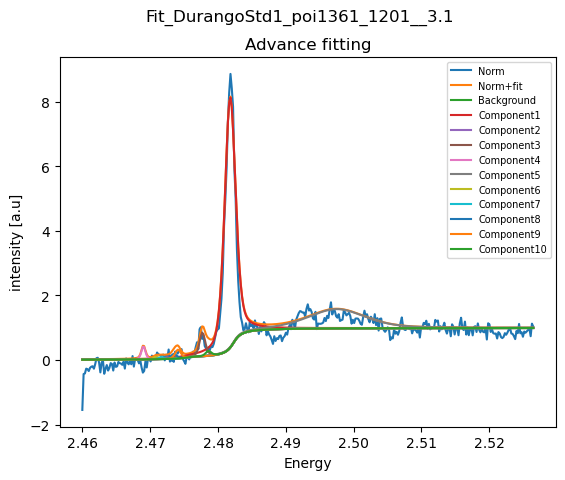


File =  DurangoStd1_poi1361_1201: 4.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 4.1
Edge/bckg ratio =  6.206150874457948
File Validated


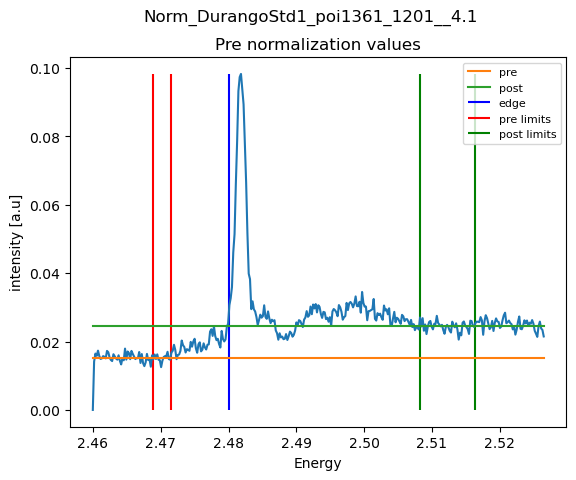

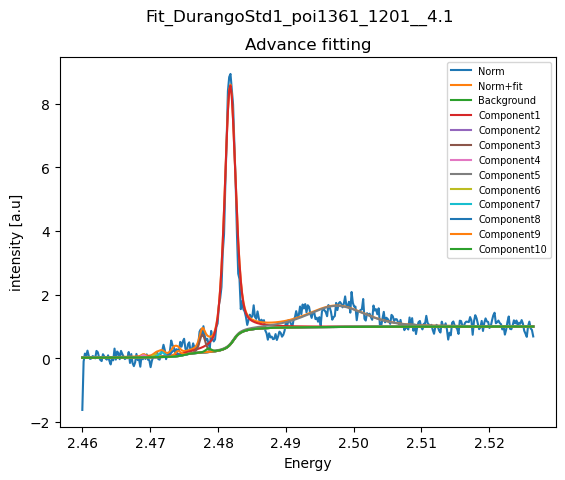


File =  DurangoStd1_poi1361_1201: 5.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 5.1
Edge/bckg ratio =  6.574038451712312
File Validated


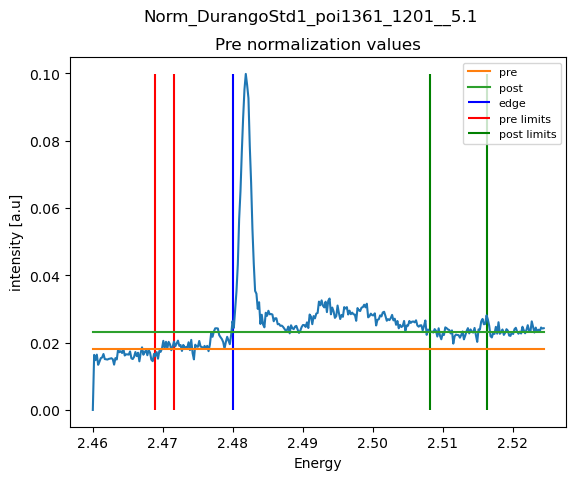

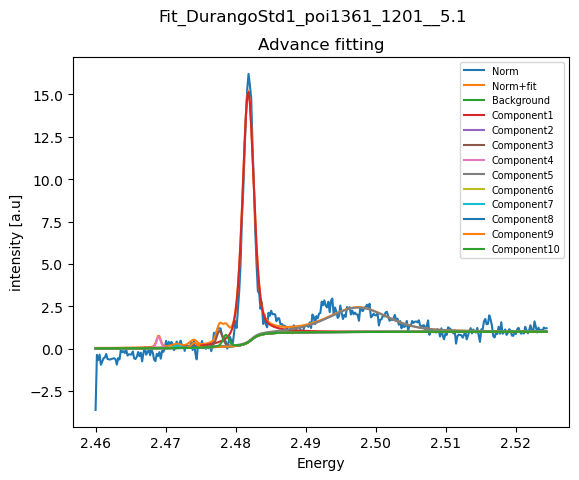


File =  DurangoStd1_poi1361_1201: 6.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 6.1
Edge/bckg ratio =  6.231459641938093
File Validated


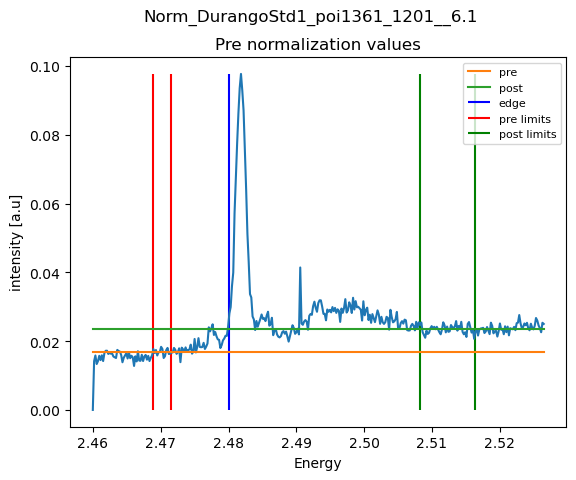

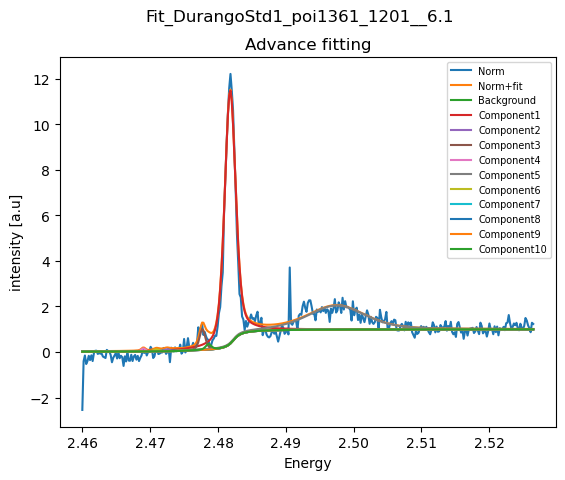


File =  DurangoStd1_poi1361_1201: 7.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 7.1
Edge/bckg ratio =  6.658191627540394
File Validated


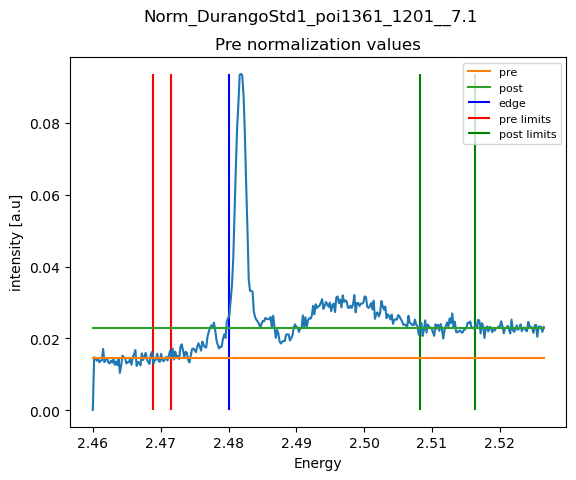

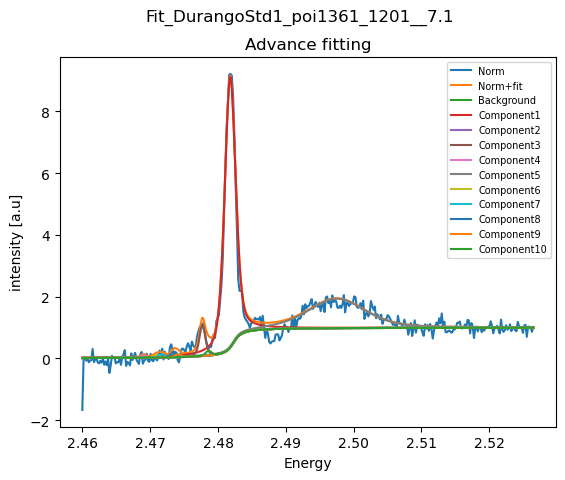


File =  DurangoStd1_poi1361_1201: 8.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 8.1
Edge/bckg ratio =  6.374861019050684
File Validated


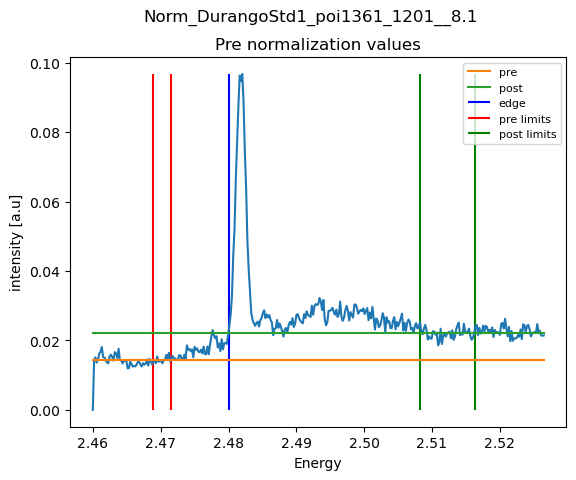

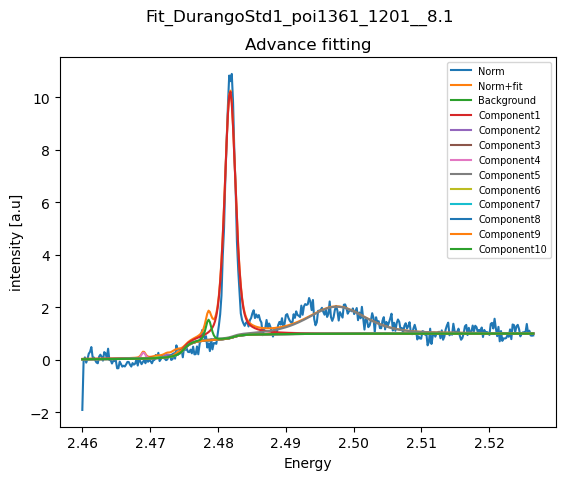


File =  DurangoStd1_poi1361_1201: 9.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 9.1
Edge/bckg ratio =  6.44537337097702
File Validated


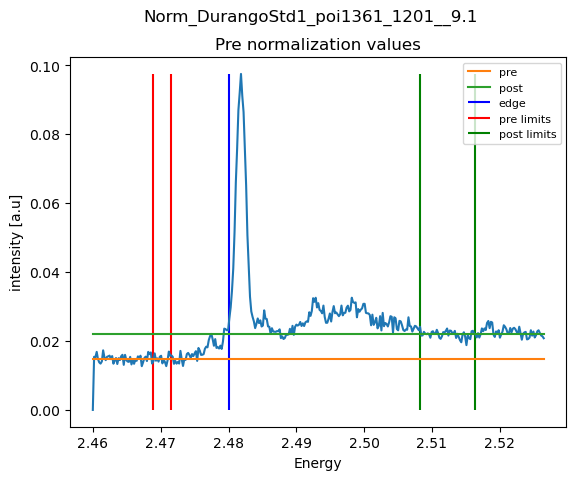

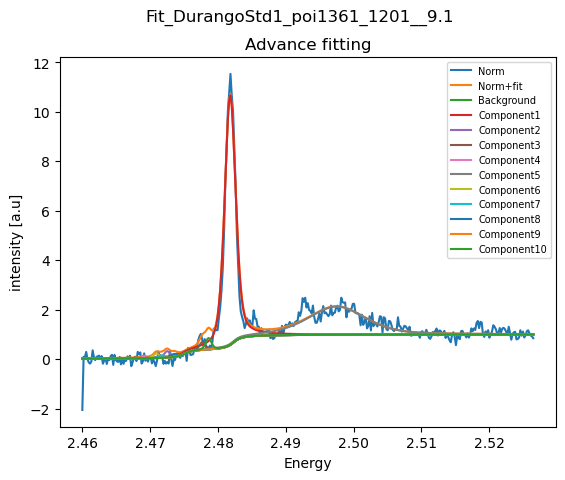


Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 10.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 11.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 2.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 3.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 4.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 5.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 6.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 7.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 8.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1361_1201: 9.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1362_1207: 2.1
Elemdetnorm not found, corr_norm done in this code =  DurangoStd1_poi1363

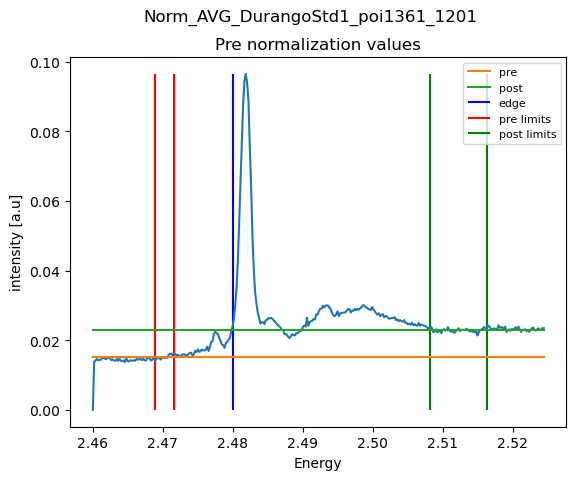

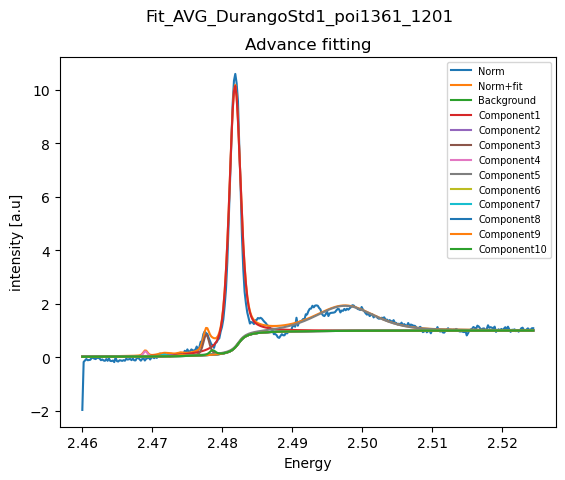

C:\Users\villalob\Anaconda3\lib\site-packages\PyMca5\PyMcaPhysics\xas\XASNormalization.py:363: RuntimeWarning: Mean of empty slice.
  postPol = [(yPost-baseLine).mean()]
C:\Users\villalob\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


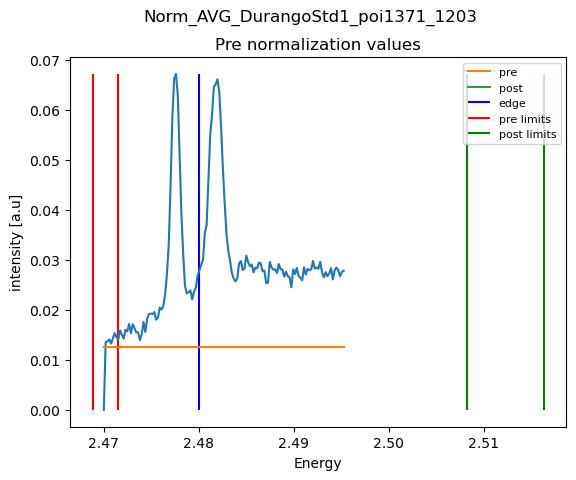

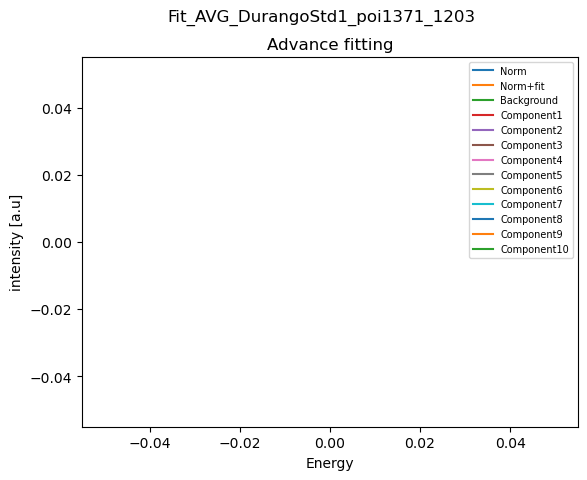


Files fitted =  12
Bad files =  0
Files with errors =  0



In [5]:
# File selection and starting lists
goodfiles = []
badfiles  = []
#fileselection()
xanesinseq = fileselectiontags()
filesforavg = goodfiles
goodfiles = [s for s in goodfiles if (any(xs in s for xs in matchers))]

goodones   = 0
badones    = 0
errorones  = 0
badonesfil = []
errorfiles = []

# Empty arrays for the final table with fitting values
fitvalarr   = []
sigvalarr   = []
filenamearr = ["Sample Name"]

# Big loop for the XANES scans
for i in range(len(goodfiles)):  
    try: 
        # Read data
        print("")
        print("File = ", goodfiles[i])
        energy, spectrum = readspectrum(goodfiles[i])

        # Validate the spectrum
        if not validatespectrum():
            print("Nooooooooooooooooooooooot Vaaaaaaaaaaaaaalid")
            badones += 1
            badonesfil.append(goodfiles[i])
            #sys.exit(1)
            continue
        
        # Normalize
        normspectrum, jump, preline, postline = normalization(energy, spectrum, edge, pre, post)

        # Fit
        fitcomponents, fitresult = fit(energy, normspectrum, cfgfilepath)

        # Saving data
        file_name = goodfiles[i]
        file_name = re.sub('[!@#$/\: ]', '_', file_name)
    
        # Saving data in individual files     
        # savesingles(energy, normspectrum, file_name)

        savespectresults = savespectresults.lower()
        if savespectresults == "yes":
            savedatapn(energy, normspectrum, file_name)
         
        savefittedresults = savefittedresults.lower()
        if savefittedresults == "yes":
            parameters, fitvalue, sigmavalue = fitresults()
            filenamearr.append(file_name)
            if i == 0:
                fitvalarr.append(parameters)
                sigvalarr.append(parameters[:-1])
                fitvalarr.append(fitvalue)
                sigvalarr.append(sigmavalue)
            else:
                fitvalarr.append(fitvalue)
                sigvalarr.append(sigmavalue)
            
        # Plot 
        showeachplot = showeachplot.lower()
        if showeachplot == "yes":
            plotting( energy, spectrum, normspectrum, file_name)

        goodones += 1  # To count how many files were good and were fitted
    except Exception as ex:
        print("The error exception in the main loop is = ", ex)
        errorones += 1
        errorfiles.append(goodfiles[i])
        continue


 # Loop for saving averaged spectra 
saveaverage = saveaverage.lower()
if saveaverage == "yes":
    avgenergylist, avgspectrumlist, avgfilenamelist = averaging()
    print("")
    print("Number of scans files averaged = ", len(avgenergylist))
    for i in range(len(avgenergylist)):
        try: 
            # Read data
            avgenergy   = avgenergylist[i]
            avgspectrum = avgspectrumlist[i]
            avgfilename = avgfilenamelist[i]
            
            # Normalize
            avgnormspectrum, jump, preline, postline = normalization(avgenergy, avgspectrum, edge, pre, post)
            
            # Plotting normalized spectra
            # plot(avgenergy, avgspectrum, avgfilename)
            
            # Fit
            fitcomponents, fitresult = fit(avgenergy, avgnormspectrum, cfgfilepath)

            # Fixing name for averaged files
            avgfilename = re.sub('[!@#$/\: ]', '_', avgfilename)
            avgfilename = avgfilename.split("_")
            avgfilename = [element for element in avgfilename[:-2]] # Removing the last number of the name
            avgfilename = "_".join(avgfilename)

            # Saving each data in individual files     
            # savesingles(avgenergy, avgnormspectrum, avgfilename)

            savespectresults = savespectresults.lower()
            if savespectresults == "yes":
                savedatapn(avgenergy, avgnormspectrum, avgfilename)

            savefittedresults = savefittedresults.lower()
            if savefittedresults == "yes":
                parameters, fitvalue, sigmavalue = fitresults()
                filenamearr.append(avgfilename)
                if i == 0:
                    fitvalarr.append(fitvalue)
                    sigvalarr.append(sigmavalue)
                else:
                    fitvalarr.append(fitvalue)
                    sigvalarr.append(sigmavalue)
                
            # Plot
            showeachplot = showeachplot.lower()
            if showeachplot == "yes":
                plotting(avgenergy, avgspectrum, avgnormspectrum, avgfilename)

            goodones += 1  # To count how many files were good and were fitted

        except Exception as ex:
            print("The error exception in the avg loop is = ", ex)
            errorones += 1
            errorfiles.append(avgfilename[i])
            continue


# Saving the table with each component Fitted and sigma Value
savefittedresults = savefittedresults.lower()
if savefittedresults == "yes":

    file_name = file_name.split("_")
    file_name = [element for element in file_name[:-1]] # Removing the last number
    file_name = "_".join(file_name)
   
    df_fit = pd.DataFrame(fitvalarr)
    df_fit.insert(0, "File_name_for_the_fit_array", filenamearr)
    df_fit.to_csv(outpath +  file_name + "All_Scans_Fitted_Values.csv", index=False, header=False, float_format='%10.6f')

    df_sig = pd.DataFrame(sigvalarr)
    df_sig.insert(0, "File_name_for_the_sigma_array", filenamearr)
    df_sig.to_csv(outpath +  file_name + "All_Scans_Sigma_Values.csv", index=False, header=False, float_format='%10.6f')


# Prints with information of the good and bad files
print("")
print("Files fitted = ", goodones)
print("Bad files = " , badones) 
print("Files with errors = " ,errorones) 
print("")
if len(badonesfil) > 0:
    print("List with bad files:")
    pprint(badonesfil)
    print("")
if len(errorfiles) > 0:
    print("List with error files:")
    pprint(errorfiles)
# End of the code


In [6]:
print("FINISH!!!")

FINISH!!!
